# **Openlane backend flow with OpenRAM macros**

## **Objectives**
- Synthesize the simulated RTL project.
- Replace and harden the behaviour SRAM modules (your data/instruction memory) in Verilog with the real memory macros generated by OpenRAM in floorplan.
- Finish the [Openlane](https://openlane.readthedocs.io/en/latest/flow_overview.html) hardware backend flow.
- Analyze the results step-by-step and have a basic understanding of the RTL-to-GDSII procedure.

## **Tips**
- The entire CA exercise session requires ESAT IT infrastructure to achieve full functionalities, such as using NC Verilog (Cadence) for simulation.
- However, this **Backend** session is fully open-source software based. Hence, you can also set up the environment on any linux system.
    - The `conda-env` build takes up **$\sim$3 GB**. Each full-flow execution will generate **4$\sim$6 GB** output data under `runs/`. 
    - Hence, if your ESAT disk quota is not sufficient, you can conduct this part of experiments on your own device after you have completed the simulation step.
- Suggestion when encounter fail: try to finish the Full Flow **even if the synthesis or floorplan run fails** (e.g., cannot meet timing). Sometimes it can be "synthesis fail，floorplan fail，full flow success".

<img src="./Figs/flow_v1.png" width=720 />

## **Helper functions and scripts**

In [17]:
import os, time
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.frame import DataFrame
import pandas as pd
pd.set_option('precision', 3)
pd.set_option('display.width', 200)
pd.set_option('max_colwidth', 90)

In [18]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [19]:
%%writetemplate openlane_visualization.sh

source setup.sh
flow.tcl -interactive -file interactive.ol


In [20]:
%%writetemplate interactive.ol

# placeholder

## **Project-specific Environment Variables**
- Please modify the `RTL_PATH` -> `NID`, `EXTRA_MACRO_PATH`, and `DESIGN_NAME` to locate your project source.
- You can also toggle `CORE_NUM`, `TAG`, etc if you like. 
    - The `CORE_NUM` is the number of thread in the computer that will be used for speeding up the backend flow. 
    - `TAG` is the identification of the run, which later you can see in your ./runs/ folder. Note that to prevent different backend flow runs from overwriting, `TAG` need to be updated. 
- Please also speficy a `CLOCK_PERIOD` to your desired speed (Default: 100ns -> 10 MHz).

In [21]:
# Project-specific Environment Variables

# NID = "SOLUTION1_simple_program_and_MULT1"
# NID = "SOLUTION2_multiplication_support_MULT2"
NID = "SOLUTION3_pipeline_basic_MULT2"
# NID = "SOLUTION4_pipeline_hazard_MULT3"
# NID = "SOLUTION5_pipeline_creative_hazard_MULT4"

TAG = "{}_{}".format(time.strftime("%y%m%d-%H%M%S", time.localtime()), NID)
CORE_NUM = os.popen("nproc").read().split("\n")[0]

DESIGN_NAME = "cpu"
CLOCK_PERIOD = 20 # in nanoseconds
RTL_PATH = f"../Verilog/RTL_{NID}"
EXTRA_MACRO_PATH = "OpenRAM_output"

# OpenRAM Macro Path
# LEF files are abstract representations of hard macroblocks, such as OpenRAM macros.
EXTRA_LEFS = ' '.join(os.popen("find {} -name \"*.lef\" -maxdepth 1".format(EXTRA_MACRO_PATH, )).read().split("\n")[:-1])
# Configure the GDS files of the hard macro.
EXTRA_GDS_FILES = ' '.join(os.popen("find {} -name \"*.gds\" -maxdepth 1".format(EXTRA_MACRO_PATH, )).read().split("\n")[:-1])
# Liberty flow contains the timings and description of I/O of the macro. It is used in Timing analysis and in synthesis.
EXTRA_LIBS = ' '.join(os.popen("find {} -name \"*.lib\" -maxdepth 1".format(EXTRA_MACRO_PATH, )).read().split("\n")[:-1])

%env TAG = {TAG}
%env DESIGN_NAME = {DESIGN_NAME}
%env CORE_NUM = {CORE_NUM}

env: TAG=230524-154153_SOLUTION3_pipeline_basic_MULT2
env: DESIGN_NAME=cpu
env: CORE_NUM=6


# **Synthesis Preparation Stage [optional]**
- The first decision in synthesis is determining the optimal synthesis strategy `SYNTH_STRATEGY` for your design.
- Openlane has several presets during the optimization of synthesis, in terms of the **AREA/DELAY** tradeoff.
- There are in total 9 [presets](https://openlane.readthedocs.io/en/latest/reference/configuration.html#synthesis) `DELAY 0-4/AREA 0-3`, which can be explored via command-line option `-synth_explore`. 
- Depending on your RTL design, the Openlane will explore for you which preset has the best outcome. This step is **Synthesis Exploration**.

## **Notes**
- The `synth_explore` option (in 2.3) allows for determining the ideal synthesis strategy for performing synthesis on a design.
- The `SYNTH_STRATEGY` definition (in 3.1) allows you to access multiple synthesis scripts/recipes for **abc** tool based on area, delay settings. 
- However, the synthesis exploration step can take long. So, We initially skip this stage to save some time by setting below `RUN_SYNTH_EXPLORATION = False`.
- If you are interested, please feel free to explore this part and report your findings. The optimal area vs delay recipe for the type of design is not always obvious or consistent as seen from initial testing.

In [43]:
# Global switch for this synthesis preparation stage (by default, we turn it off)
RUN_SYNTH_EXPLORATION = True

## **Update the Openlane Configuration**
- Initial configuration.

In [44]:
%%writetemplate config.tcl

set ::env(STD_CELL_LIBRARY) "sky130_fd_sc_hd"

set ::env(DESIGN_NAME) {DESIGN_NAME}
set ::env(VERILOG_FILES) {RTL_PATH}/*.v
set ::env(CLOCK_PORT) "clk"
set ::env(CLOCK_NET) "clk"
set ::env(CLOCK_PERIOD) {CLOCK_PERIOD}
set ::env(CLOCK_TREE_SYNTH) 1
set ::env(IO_PCT) 0

set ::env(DESIGN_IS_CORE) 1      
set ::env(SYNTH_MAX_FANOUT) 30

# Connect the layout files and abstracts
# Connect the blackbox information and timing data
set ::env(EXTRA_LEFS)      [list {EXTRA_LEFS}]
set ::env(EXTRA_GDS_FILES) [list {EXTRA_GDS_FILES}]
set ::env(EXTRA_LIBS)      [list {EXTRA_LIBS}]

## **Trigger the Openlane Execution (Synthesis Exploration)** ~20min
- We put these results aside the main `runs/` folder for you to check later at anytime.

In [45]:
if RUN_SYNTH_EXPLORATION:
    !flow.tcl -design . -ignore_mismatches -tag $TAG-synth_explore -overwrite -synth_explore -to synthesis

OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.tcl'...
[INFO]: PDK Root: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-122823_SOLUTION3_pipeline_basic_MULT2-synth_explore
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[INFO]: Running Synthesis Exploration...
[INFO]: This is a Synthesis Exploration and so no need to remove the defparam lines.


## **Synthesis Exploration Analysis**
- The **Synthesis Exploration** is considered as **a preparation step** in the OpenLane procedure.
    - You will first get a summary table showing the tradeoff of these presets on your design.
    - We also provide a pie-chart plotting function below for you to analyze the detailed cell-amount breakdown on different presets (By setting `STRATEGY_list` and `PLOT_TOP_K`). 
- You will get an insight of how different **synthesis optimizations** and **standard cell mapping methods** would impact the hardware overhead. 

In [46]:
if RUN_SYNTH_EXPLORATION:
    FILENAME=f"runs/{TAG}-synth_explore/reports/synthesis/0-exploration_analysis.html"
else:
    FILENAME=0
# Summary Table
from IPython.display import HTML
HTML(filename=FILENAME)

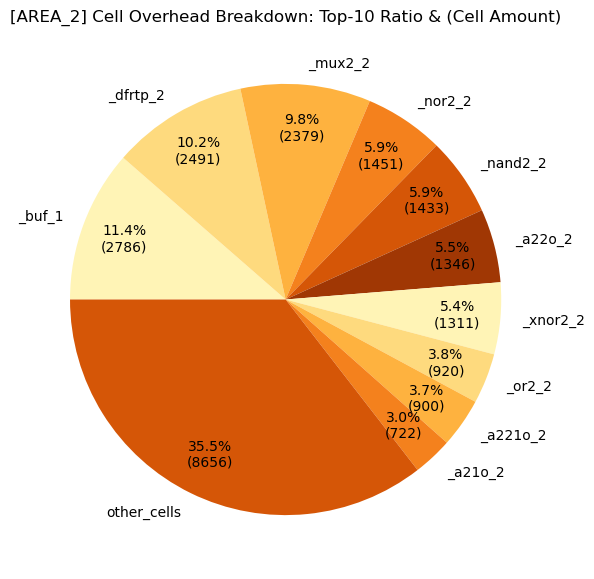

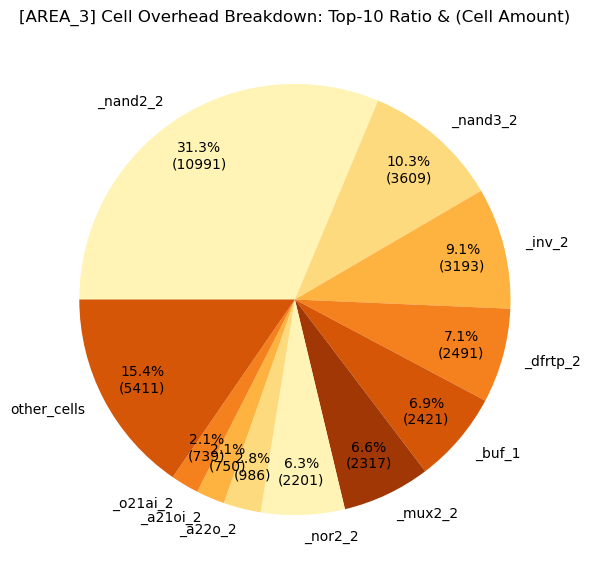

In [47]:
if RUN_SYNTH_EXPLORATION:
    # Cell Breakdown Pie Chart
    STRATEGY_list=["AREA_2","AREA_3"] # modify the list to your interest, according to the summary table
    PLOT_TOP_K = 10 # select top-K values 

    from operator import itemgetter
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
        return my_autopct
    colors = sns.color_palette("YlOrBr")

    for strategy in STRATEGY_list:
        with open(f"runs/{TAG}-synth_explore/reports/synthesis/0-synthesis.{strategy}.stat.rpt", "r") as f:
            _dict = {}
            for _lines in f.readlines():
                _tmp_list = _lines.split()
                if len(_tmp_list) > 1:
                    if "cells:" in _tmp_list:
                        _rpt_cells_sum = int(_tmp_list[-1])
                    if "sky130" in _tmp_list[0]:
                        _dict[_tmp_list[0]] = int(_tmp_list[1])
            _sorted_dict = {key:value for key, value in sorted(_dict.items(), key=lambda x: x[-1], reverse=True)}
            _TOP_K_dict_key_list = list(_sorted_dict.keys())[:PLOT_TOP_K]
            _TOP_K_dict_key_list_simple = [k.split("sky130_fd_sc_hd_")[-1] for k in _TOP_K_dict_key_list]
            _labels_union = _TOP_K_dict_key_list_simple + ["other_cells"]
            
            _data = list(itemgetter(*_TOP_K_dict_key_list)(_dict))
            _data.append(_rpt_cells_sum- sum(_data))
            
            plt.figure(figsize=(7,7))
            plt.pie(x=_data, labels=_labels_union, colors=colors, startangle=180, counterclock=0, autopct=make_autopct(_data), pctdistance=0.8)
            plt.title("[{}] Cell Overhead Breakdown: Top-{} Ratio & (Cell Amount)".format(strategy, PLOT_TOP_K))
            plt.show()

# **Synthesis Stage**
- Perform the first **synthesis-only** run.
    - Check the generated design under folder: `runs/{TAG}/results/synthesis`.
    - Check the reports under folder: `runs/{TAG}/reports/synthesis`.
    - Check the logs under folder: `runs/{TAG}/logs/synthesis`.


## **Update the Openlane Configuration**
- From the results of **Synthesis Exploration**, you can now choose a synthesis preset as `SYNTH_STRATEGY` in the next ***config.tcl***, by default `AREA 0` is used.
- To provide a human-readable format in critical-path analysis, we also use `SYNTH_NO_FLAT` from now on to preserve hierarchical RTL module names in the timing (STA) and area reports.

In [22]:
# DELAY 0-4/AREA 0-3
SYNTH_STRATEGY = "\"AREA 3\""

In [23]:
%%writetemplate config.tcl

set ::env(STD_CELL_LIBRARY) "sky130_fd_sc_hd"

set ::env(DESIGN_NAME) {DESIGN_NAME}
set ::env(VERILOG_FILES) {RTL_PATH}/*.v
set ::env(CLOCK_PORT) "clk"
set ::env(CLOCK_NET) "clk"
set ::env(CLOCK_PERIOD) {CLOCK_PERIOD}
set ::env(CLOCK_TREE_SYNTH) 1
set ::env(IO_PCT) 0

set ::env(DESIGN_IS_CORE) 1      
set ::env(SYNTH_MAX_FANOUT) 30

set ::env(SYNTH_STRATEGY) {SYNTH_STRATEGY}
set ::env(SYNTH_NO_FLAT) 1

# Connect the layout files and abstracts
# Connect the blackbox information and timing data
set ::env(EXTRA_LEFS)      [list {EXTRA_LEFS}]
set ::env(EXTRA_GDS_FILES) [list {EXTRA_GDS_FILES}]
set ::env(EXTRA_LIBS)      [list {EXTRA_LIBS}]

## **Trigger the Openlane Execution (Synthesis)** ~3min

In [24]:
!flow.tcl -design . -ignore_mismatches -tag $TAG -overwrite -to synthesis

OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.tcl'...
[INFO]: PDK Root: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-154153_SOLUTION3_pipeline_basic_MULT2
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[STEP 1]
[INFO]: Running Synthesis (log: runs/230524-154153_SOLUTION3_pipeline_basic_MULT2/logs/synthesis/1-synthesis.log)...
[STEP 2]
[INFO

## **Synthesized Timing & Area Analysis**
- For the **Synthesis** stage
    - Hierarchical and Flattened RTL is stored in `runs/{TAG}/results/synthesis`.
    - Timing and Area summary is in `runs/{TAG}/reports/synthesis`.
    - Hierarchical Area/Cell report can be extracted from `runs/{TAG}/logs/synthesis/1-synthesis.log` as shown in the next code blocks.
- For the following stages, Netlist generation and STA will be performed multiple times. The resulting output files can be analyzed with the same methods.

In [25]:
# Extract the hierarchical area report of modules. 
# The output will be saved to "runs/{TAG}/reports/synthesis/1-synthesis.area_breakdown.rpt".
LOG_PATH = f"./runs/{TAG}/logs/synthesis/1-synthesis.log"

_stdout = os.popen(f"grep -rn \"Chip area for module\" {LOG_PATH}").read()
_stdout = [_str.split() for _str in _stdout.split("\n")]
_df = DataFrame(_stdout[:-1]).drop(columns=[1,2,3,4])
_df.rename(columns={0:"Line #", 5:"Module Name", 6:"Area(um^2)"}, inplace=True)
_df["Area(um^2)"] = _df["Area(um^2)"].astype(float)
_df["Area(%)"] = _df.iloc[:, -1] / _df.iloc[-1, -1] * 100

print(_df)
_df.to_csv(f"./runs/{TAG}/reports/synthesis/1-synthesis.area_breakdown.csv", float_format='%.3f')

   Line #                                                            Module Name  Area(um^2)  Area(%)
0   7635:      '$paramod$4051db0e2139556c372a059ae92d205f75e1b091\reg_arstn_en':    5031.075    0.696
1   7656:      '$paramod$4395cecea55c532d94088b1992b59bbfe4ad518a\reg_arstn_en':    7978.902    1.104
2   7677:      '$paramod$570fb8dd68386f316f65f4a2c029d68f9bee6533\reg_arstn_en':   15090.723    2.088
3   7695:      '$paramod$6136cc844849bfbf02d165df8f5dca9405303543\reg_arstn_en':    3328.192    0.461
4   7716:      '$paramod$f5a83fac1632e39006d9dfc9105b2fc3be4e984d\reg_arstn_en':   14092.266    1.950
5   7811:            '$paramod\alu\DATA_W=s32'00000000000000000000000001000000':  168935.773   23.380
6   7861:    '$paramod\branch_unit\DATA_W=s32'00000000000000000000000001000000':    6545.027    0.906
7   7878:          '$paramod\mux_2\DATA_W=s32'00000000000000000000000001000000':    1646.579    0.228
8   7928:             '$paramod\pc\DATA_W=s32'00000000000000000000000001000000':  

# **Floorplan Stage #1 - Initial Floorplan**


- Obtain the synthesized macro module names from ***runs/{TAG}/results/synthesis/{DESIGN_NAME}.v***.
- Generate the configuration string **FP_PDN_MACRO_HOOKS** for Power/Ground PDN (*Power Distribution Network*) connections with these macro module names.
- Add floorplan settings to the ***config.tcl*** file.

In [10]:
# Add the PDN connections between SRAM cells and the power/ground nets.
# Syntax: <instance_name> <vdd_net> <gnd_net> <vdd_pin> <gnd_pin>

sram_macro_list = ["sky130_sram_2rw_32x128_32", "sky130_sram_2rw_64x128_64"]
VDD_NETS = "vccd1"
GND_NETS = "vssd1"

FP_PDN_MACRO_HOOKS = ""
SRAM_MACRO_NAMES = []
for macro_name in sram_macro_list:
    _stdout = os.popen(f"grep -rn {macro_name} ./runs/$TAG/results/synthesis/{DESIGN_NAME}.v").read()
    print("Found macro instance:\n{}".format(_stdout))
    _name = _stdout.split("\\")[-1].split(" ")[0]
    _name = _name.replace(_name.split(".")[1], "*")
    FP_PDN_MACRO_HOOKS += " "\
        + _name \
        + f"      {VDD_NETS} {GND_NETS} {VDD_NETS} {GND_NETS},\\\n"  
    SRAM_MACRO_NAMES.append(_name)
FP_PDN_MACRO_HOOKS = FP_PDN_MACRO_HOOKS.strip(",\\\n").replace("[", "\\[").replace("]", "\\]")


print("Adding configurations:\n\nset ::env(FP_PDN_MACRO_HOOKS) \"\\\n{}\"".format(FP_PDN_MACRO_HOOKS))

Found macro instance:
177085:  sky130_sram_2rw_32x128_32 \instruction_memory.process_for_mem[0].dram_inst  (

Found macro instance:
176520:  sky130_sram_2rw_64x128_64 \data_memory.process_for_mem[0].spad_inst  (

Adding configurations:

set ::env(FP_PDN_MACRO_HOOKS) "\
 instruction_memory.*.dram_inst      vccd1 vssd1 vccd1 vssd1,\
 data_memory.*.spad_inst      vccd1 vssd1 vccd1 vssd1"


## **Update the Openlane Configuration**

In [11]:
%%writetemplate config.tcl

set ::env(STD_CELL_LIBRARY) "sky130_fd_sc_hd"

set ::env(DESIGN_NAME) {DESIGN_NAME}
set ::env(VERILOG_FILES) {RTL_PATH}/*.v
set ::env(CLOCK_PORT) "clk"
set ::env(CLOCK_NET) "clk"
set ::env(CLOCK_PERIOD) {CLOCK_PERIOD}
set ::env(CLOCK_TREE_SYNTH) 1
set ::env(IO_PCT) 0

set ::env(DESIGN_IS_CORE) 1      
set ::env(SYNTH_MAX_FANOUT) 30

set ::env(SYNTH_STRATEGY) {SYNTH_STRATEGY}
set ::env(SYNTH_NO_FLAT) 1

# Connect the layout files and abstracts
# Connect the blackbox information and timing data
set ::env(EXTRA_LEFS)      [list {EXTRA_LEFS}]
set ::env(EXTRA_GDS_FILES) [list {EXTRA_GDS_FILES}]
set ::env(EXTRA_LIBS)      [list {EXTRA_LIBS}]

# SRAM config
set ::env(VDD_NETS) "vccd1"
set ::env(GND_NETS) "vssd1"
set ::env(FP_PDN_MACRO_HOOKS) "\
{FP_PDN_MACRO_HOOKS}"

# Some floorplan empirical parameters
set ::env(FP_CORE_UTIL) 30
set ::env(FP_SIZING) relative
set ::env(PL_MACRO_CHANNEL) [list 80 80]

## **Trigger the Openlane Execution (Floorplan)** ~4min

In [12]:
!flow.tcl -design . -ignore_mismatches -tag $TAG -overwrite -to floorplan

OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.tcl'...
[INFO]: PDK Root: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-143151_SOLUTION3_pipeline_basic_MULT2
[INFO]: Removing existing /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-143151_SOLUTION3_pipeline_basic_MULT2...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]:

## **Update the Helper Script**

In [13]:
%%writetemplate interactive.ol

package require openlane
prep -design . -ignore_mismatches -tag {TAG}
set_odb ./runs/{TAG}/results/floorplan/{DESIGN_NAME}.odb
set_def ./runs/{TAG}/results/floorplan/{DESIGN_NAME}.def
or_gui


# **Floorplan Stage #2 - GUI check**
- Switch to a graphical environment to continue for GUI display (PC mornitor/VNC/...).
- Open a command-line console under the same project folder and `source setup.sh` again.
- Use the command `source openlane_visualization.sh` to invoke the OpenROAD GUI and have a look at your 1st version of the floorplan.
- In the poped-up OpenROAD GUI, you should see the chip layout similar to the example below.
    - You can hide/show different layers and toggle the design congestion heatmap from the left toolbar.
    - The right toolbar shows the details of the design/netlist.
    - Look at how the cells are distributed across the chip. You might notice a unwanted overlapping of cells and macro blocks. **Why?**

<img src="./Figs/floorplan_0_ref.png" width=800 align=center />

# **Floorplan Stage #3 - Macro Placement [Optional]**
- In the previous tutorial (4), we use automatical floorplan and placement by using `FP_CORE_UTIL` and `PL_MACRO_CHANNEL`. However, it is also possible to assign the floorplan manually. 
- Manual macro placement is useful for easier and better place-and-route process, especially for large designs with more macro blocks.
- For example, if your instruction memory is composed of **2** 32x128 macro blocks, it is preferred to put them together rather than automatically scattering them in different corners like this:

<img src="./Figs/macro_1_ref.png" width=800 align=center />

- For more details, please refer to the openlane tutorial [here](https://openlane.readthedocs.io/en/latest/tutorials/openram.html#macrocell-placement).
- Following the tutorial, you can also explore this stage yourself by switching to the *config.tcl*'s `# # Option-2: ...` in the **Full Flow** section and re-running the command `!flow.tcl ...`.

Here are some useful references for manual macro placement, including the size of macro instances and the template of macro placement configuration.

In [56]:
# Check the macro Liberty Libs for area information

for f_lef in EXTRA_LEFS.split(" "):
    !grep -n "MACRO" {f_lef}
    !grep -n "SIZE" {f_lef}

8:MACRO sky130_sram_2rw_32x128_32
10:   SIZE 470.26 BY 294.82 ;
8:MACRO sky130_sram_2rw_64x128_64
10:   SIZE 535.54 BY 425.38 ;


In [57]:
%%writetemplate macro_placement.cfg
instruction_memory.process_for_mem\[0\].dram_inst 100 600 N
data_memory.process_for_mem\[0\].spad_inst 100 100 N

You should be able to get any layout you like for the design, such as the two samples below. Although some of the layouts would be troublesome for the other backend stages that follow.

<img src="./Figs/floorplan_1_ref.png" width=560 />  <img src="./Figs/floorplan_2_ref.png" width=220 />

# **Full Flow**
- Now you have completed the beginning stages to harden the memory macros onto your chip.
- Let's complete the Tcl Configuration file with some extra backend toggles.
- Then trigger the flow.tcl for an end-to-end execution as follows.

<img src="./Figs/flow_v1.png" width=720 />

## **Update the Openlane Configuration**
- Some options for the **floorplan target core utilization** and **placement target density**.
- Some options for the **die-area configuration**.
- Some options for the **macro-placement approach**.
- Other configurations for backend optimizations and verifications.

In [14]:
%%writetemplate config.tcl

set ::env(STD_CELL_LIBRARY) "sky130_fd_sc_hd"

set ::env(DESIGN_NAME) {DESIGN_NAME}
set ::env(VERILOG_FILES) {RTL_PATH}/*.v

set ::env(CLOCK_PORT) "clk"
set ::env(CLOCK_NET) "clk"
set ::env(CLOCK_PERIOD) {CLOCK_PERIOD}
set ::env(CLOCK_TREE_SYNTH) 1
set ::env(IO_PCT) 0

set ::env(DESIGN_IS_CORE) 1      
set ::env(SYNTH_MAX_FANOUT) 30
set ::env(SYNTH_NO_FLAT) 1

set ::env(SYNTH_STRATEGY) {SYNTH_STRATEGY}
set ::env(SYNTH_NO_FLAT) 1

# Connect the layout files and abstracts
# Connect the blackbox information and timing data
set ::env(EXTRA_LEFS)      [list {EXTRA_LEFS}]
set ::env(EXTRA_GDS_FILES) [list {EXTRA_GDS_FILES}]
set ::env(EXTRA_LIBS)      [list {EXTRA_LIBS}]

# SRAM config
set ::env(VDD_NETS) "vccd1"
set ::env(GND_NETS) "vssd1"
set ::env(FP_PDN_MACRO_HOOKS) "\
{FP_PDN_MACRO_HOOKS}"
 
# Option-?: Some floorplan empirical parameters
## floorplan factor that controls the core utilization and the relative die area
set ::env(FP_CORE_UTIL) 30
# set ::env(FP_CORE_UTIL) 50
# set ::env(FP_CORE_UTIL) 65

## placement factor that controls the cell density
# set ::env(PL_TARGET_DENSITY) 0.65
# set ::env(PL_TARGET_DENSITY) 0.75
# set ::env(PL_TARGET_DENSITY) 0.85

# # Option-1: Auto DIE Area selection
set ::env(FP_SIZING) relative
# # Option-2: Manual DIE Area config
# set ::env(FP_SIZING) absolute
# set ::env(DIE_AREA) "0 0 1400 1400"

# Option-1: Auto Macro Placement
set ::env(PL_MACRO_CHANNEL) [list 80 80]
# # Option-2: Manual Macro Placement 
# set ::env(MACRO_PLACEMENT_CFG) macro_placement.cfg

# other config
set ::env(ROUTING_CORES) {CORE_NUM}
set ::env(RUN_KLAYOUT_XOR) 0
set ::env(MAGIC_DRC_USE_GDS) 0
set ::env(QUIT_ON_MAGIC_DRC) 0    

set ::env(PL_RESIZER_TIMING_OPTIMIZATIONS) 1 
set ::env(PL_RESIZER_DESIGN_OPTIMIZATIONS) 1  
set ::env(PL_RESIZER_REPAIR_TIE_FANOUT) 1  
set ::env(GLB_RESIZER_TIMING_OPTIMIZATIONS) 1  
set ::env(GLB_RESIZER_DESIGN_OPTIMIZATIONS) 1 
# Our additions:
set ::env(PL_RESIZER_SETUP_SLACK_MARGIN) 0.2
set ::env(PL_RESIZER_HOLD_SLACK_MARGIN) 0.4

set ::env(DIODE_INSERTION_STRATEGY) 3
set ::env(QUIT_ON_LONG_WIRE) 1 

## **Trigger the Openlane Execution (Full Flow)** ~40min

If you meet issue in running the flow, check 7.3 Troubleshooting first.

In [15]:
!flow.tcl -design . -ignore_mismatches -tag $TAG -overwrite

OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.tcl'...
[INFO]: PDK Root: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-143151_SOLUTION3_pipeline_basic_MULT2
[INFO]: Removing existing /users/students/r0788674/Documents/ESAT_Master_1/Computer_Architectures/CA_FastBoi/CA_Exercises/Backend/runs/230524-143151_SOLUTION3_pipeline_basic_MULT2...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]:

## **Troubleshooting**

### <span style="color:red">**Possible Issues**</span>
Please notice that we are leaving everything automatical in the place-and-route. Hence, you might encounter errors in these stages such as 
```
[ERROR GPL-0302] Use a higher -density or re-floorplan with a larger core area. 
Given target density: 0.55 
Suggested target density: 0.56
```
especially after you implement complex logics for **session 3**.
- The automation of openlane would fail if the constraints are too stringent.
- For example, `... target density` means `PL_TARGET_DENSITY`([link](https://openlane.readthedocs.io/en/latest/reference/configuration.html#placement)), relative to `FP_CORE_UTIL`([link](https://openlane.readthedocs.io/en/latest/reference/configuration.html#floorplanning)) in ***config.tcl*** 
    - The desired placement density of cells. It reflects how spread the cells would be on the core area. 1 = closely dense. 0 = widely spread.
    - Default: `PL_TARGET_DENSITY = (FP_CORE_UTIL + 10 + 5 * GPL_CELL_PADDING) / 100.0`. 
    - It configures the desired placement density of cells. In other words, it reflects how spread the cells would be on the core area.
    
Here are some qualitative relationship between these tweaks:
- **Higher** `PL_TARGET_DENSITY` -> **Smaller** area for logic cell and **Larger** area left for macros -> **Easier** for macro placement while **Harder** for routing (routing congestion).
- **Higher** `FP_CORE_UTIL` -> **Smaller** chip area (recall that `set ::env(FP_SIZING) relative`) -> **Harder** to place all the pins and cells (unplaced pins and nets).

### <span style="color:green">**Solutions and Suggestions**</span>  
Therefore, you have several choices to correct the flow. 
- Make more space to allow the automatic placement to succeed.
    - Set a denser `PL_TARGET_DENSITY` instead of the default value controlled by `FP_CORE_UTIL`.
    - Get a larger `DIE_AREA` by manual setting or by relative `FP_CORE_UTIL` control. 
- Place the macros manually instead of leaving it to openlane.
    - Allow some space in-between to route necessary logics in/out the macro blocks.
    - Allow enough space to place-and-route the remaining logics.

Please adjust between the `# Option ...` settings in ***config.tcl*** and refer to the previous **Floorplan Stage #3: Macro Placement** to try out these ideas.

# **Analysis and Discussion**

## **Update the Helper Script**

In [28]:
%%writetemplate interactive.ol

package require openlane
prep -design . -ignore_mismatches -tag {TAG}
set_odb ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/floorplan/{DESIGN_NAME}.odb
set_def ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/floorplan/{DESIGN_NAME}.def
or_gui

set_odb ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/placement/{DESIGN_NAME}.odb
set_def ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/placement/{DESIGN_NAME}.def
or_gui

set_odb ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/routing/{DESIGN_NAME}.odb
set_def ./runs/230524-143151_SOLUTION3_pipeline_basic_MULT2/results/final/def/{DESIGN_NAME}.def
or_gui

- If you have seen <span style="color:green">[SUCCESS]: Flow complete.</span>, congratulations! You have got the final GDSII for your processor design.
- Pay attention to the openlane logs and try to get the overview of how the conversion is carried out step-by-step.
- You can also find details of all the stages in the toolchain logs/reports/results under folder ***`runs/{TAG}/`***, which is organized following [this structure](https://openlane.readthedocs.io/en/latest/flow_overview.html#openlane-output). 
- Use command `source openlane_visualization.sh` again to invoke the OpenROAD GUI and have a look at your 1st version of floorplan. It will show layouts from 3 critical stages. Close the GUI each time you would like to check the layout of next stage.
- OpenLane/OpenRAM/Sky130A are both open-source backend tools which are still immature. You can see those imperfections in `manufacturability.rpt`, `OpenRAM_output/*.html`, and etc. 
- Try to complete the project report with what you have learnt from this notebook.

# **Summary and Take-aways**
- With this tutorial, you have completed an RTL-to-GDSII chip design procedure, hardening your customized RISC-V processor cores onto a real chip. Congratulations! Theoretically, the green light of chip fabrication is a few verifications away. 
- The OpenLane/OpenRoad workflow represents a typical hardware backend workflow, which is also a widely-used standard in academia/industry chip fabrication.
- This tutorial is powered by open-source PDK/toolchain development efforts that lower the entry barrier of this field, especially for educational purposes.
- However, keep in mind that all these tools are still under early design stages, inferier and unstable than commercial softwares like Synopsys and Cadence.
- We hope that you could benefit from this exercise session for your future IC development. Good Luck!

![SegmentLocal](Figs/flow_steps_demo.gif "backend_flow_demo")

- Last but not least, if you would like to have some souvenirs of your own chip design. Please use Screenshot/Save functions embedded in those GUI tools.
- The following code will convert the final GDS to PNG images. Feel free to switch it on if you want. Note that it might take extra hours to generate a PNG >100MB from the entire layout.

In [ ]:
_png_gen_ = False

if _png_gen_:
    import pathlib
    import gdstk
    import cairosvg

    gdss = sorted(pathlib.Path('runs').glob(f'{TAG}/results/final/gds/*.gds'))
    library = gdstk.read_gds(gdss[-1])
    top_cells = library.top_level()
    top_cells[0].write_svg(f'{DESIGN_NAME}-{TAG}.svg')
    cairosvg.svg2png(url=f'{DESIGN_NAME}-{TAG}.svg', write_to=f'{DESIGN_NAME}-{TAG}.png')

# **Debug and Tutorial Reference**
- https://openlane.readthedocs.io/en/latest/usage/chip_integration.html?highlight=lvs#hardening-the-full-chip
- https://openlane.readthedocs.io/en/latest/reference/index.html